In [109]:
## import
import torch,torchvision
from torch import nn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.functional as F

In [110]:
img_size=32
channels=1
batch_size=32

In [111]:
## 数据准备
dataset=torchvision.datasets.MNIST(
    './',
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(img_size),transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]
    
    ) 
)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,drop_last=True)
inputs,labels=next(iter(dataloader))
inputs.shape,labels.shape

(torch.Size([32, 1, 32, 32]), torch.Size([32]))

In [112]:
## encoder
class Encoder(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        input_size=channels*img_size*img_size
        self.z_dim=z_dim
        self.layers=nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size,512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512,0.8),
            nn.Linear(512,512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512,0.8),
            nn.Linear(512,self.z_dim)
        )
    def forward(self,x):
        return self.layers(x)
    
encoder=Encoder(100)
code=encoder(inputs)
code.shape

torch.Size([32, 100])

In [113]:
## decoder
class Decoder(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        output_size=channels*img_size*img_size
        self.z_dim=z_dim
        self.layers=nn.Sequential(
            nn.Linear(self.z_dim,512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512,0.8),
            nn.Linear(512,512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512,0.8),
            nn.Linear(512,output_size),
            nn.Tanh(),
        )
    def forward(self,x):
        return self.layers(x).view(-1,channels,img_size,img_size)
decoder=Decoder(100)
img=decoder(code)
img.shape

torch.Size([32, 1, 32, 32])

In [78]:
class Discriminator(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        input_size=z_dim*2
        self.layers=nn.Sequential(
            nn.Linear(input_size,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout1d(0.5),
            nn.Linear(1024,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout1d(0.5),
            nn.Linear(1024,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout1d(0.5),
            nn.Linear(1024,1)
        )
        
    def forward(self,code):
        return self.layers(code)
d=Discriminator(100)
d(torch.cat([code,code],dim=1)).shape
        
    

torch.Size([32, 1])

In [114]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr=0.0002
b1=0.5
b2=0.999
batches=10000
z_dim=128
G_trains=1
D_trains=2
e_model=Encoder(z_dim).to(device)
te_model=Encoder(z_dim).to(device)
g_model=Decoder(z_dim).to(device)
d_model=Discriminator(z_dim).to(device)


In [115]:
import itertools
optimizer_G=torch.optim.Adam(itertools.chain(e_model.parameters(),g_model.parameters()),
                              lr=lr, betas=(b1, b2))
optimizer_D= torch.optim.Adam(itertools.chain(te_model.parameters(),d_model.parameters()),
                                 lr=lr, betas=(b1, b2))



In [116]:
cuda=1 if torch.cuda.is_available() else 0
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def show(imgs,figsize=(6,6)):
    plt.figure(figsize=figsize)
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()

fixed_z=FloatTensor(np.random.normal(size=(batch_size,z_dim)))

[batch 29200/100000]:


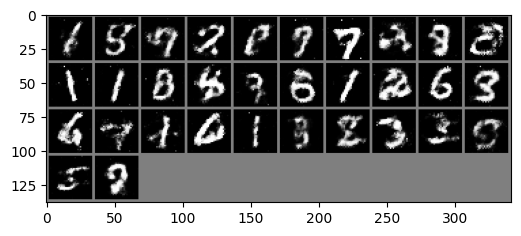

iter: 29201, d_loss: -1.685389518737793, g_loss: 6.47537088394165
iter: 29202, d_loss: -1.8455233573913574, g_loss: 6.802600383758545
iter: 29203, d_loss: -2.0953752994537354, g_loss: 7.460484504699707
iter: 29204, d_loss: -1.9641709327697754, g_loss: 6.4956135749816895
iter: 29205, d_loss: -1.5055118799209595, g_loss: 6.398030757904053
iter: 29206, d_loss: -1.690401554107666, g_loss: 6.277087211608887
iter: 29207, d_loss: -1.7313402891159058, g_loss: 6.189640522003174
iter: 29208, d_loss: -1.6037790775299072, g_loss: 6.177425861358643
iter: 29209, d_loss: -1.725374698638916, g_loss: 6.676809787750244
iter: 29210, d_loss: -1.9077057838439941, g_loss: 6.407105922698975


KeyboardInterrupt: 

In [117]:
batches=100000
g_loss_list=[]
d_loss_list=[]
def get_infinite_data(dataloader):
    while True:
        for image,_ in dataloader:
            yield image
train_dataloader=get_infinite_data(dataloader)
def get_batch():
    return train_dataloader.__next__().to(device)
def set_trainable(model,state):
    for param in model.parameters():
            param.requires_grad_(state)
for i in range(batches):
    set_trainable(e_model,False)
    set_trainable(g_model,False)
    set_trainable(te_model,True)
    set_trainable(d_model,True)
    for _ in range(D_trains):
        x_real=get_batch()
        z_fake=FloatTensor(np.random.normal(size=(batch_size,z_dim)))
        x_fake=g_model(z_fake)
        z_real=e_model(x_real)
        x_real_te=te_model(x_real)
        x_fake_te=te_model(x_fake)
        xz_real=torch.cat([x_real_te,z_real],dim=1)
        xz_fake=torch.cat([x_fake_te,z_fake],dim=1)
        
        xz_real_score=d_model(xz_real)
        xz_fake_score=d_model(xz_fake)
        
        optimizer_D.zero_grad()
        
        d_loss=xz_real_score-xz_fake_score
        d_loss=d_loss[:,0]
        d_norm=10*torch.mean((x_real-x_fake).abs(),dim=(1,2,3))+torch.mean((z_real-z_fake).abs(),dim=1)
        d_loss=torch.mean(-d_loss+0.5*d_loss**2/d_norm)
        
        d_loss.backward()
        optimizer_D.step()
        #print(d_loss)
    
    set_trainable(e_model,True)
    set_trainable(g_model,True)
    set_trainable(te_model,False)
    set_trainable(d_model,False)
    for _ in range(G_trains):
        x_real=get_batch()
        z_fake=FloatTensor(np.random.normal(size=(batch_size,z_dim)))
        x_fake=g_model(z_fake)
        z_real=e_model(x_real)
        x_real_rec=g_model(z_real.detach())
        z_fake_rec=e_model(x_fake.detach())
        
        x_real_te=te_model(x_real)
        x_fake_te=te_model(x_fake)
        xz_real=torch.cat([x_real_te,z_real],dim=1)
        xz_fake=torch.cat([x_fake_te,z_fake],dim=1)
        
        xz_real_score=d_model(xz_real)
        xz_fake_score=d_model(xz_fake)
        
        optimizer_G.zero_grad()
        
        g_loss=torch.mean(xz_real_score-xz_fake_score)+2*torch.mean(
            torch.square(z_fake-z_fake_rec))+3*torch.mean(torch.square(x_real-x_real_rec))
        
        g_loss.backward()
        optimizer_G.step()
    
    print(f"iter: {i}, d_loss: {d_loss}, g_loss: {g_loss}")
    
    batch_done=i
    if(batch_done%100==0):
        clear_output()
        print('[batch %d/%d]:'%(i,batches))
        with torch.no_grad():
            fake_img=g_model(fixed_z)
        show(fake_img)
        #plt.plot(range(batch_done+1),g_loss_list)
        #plt.plot(range(batch_done+1),d_loss_list)
        
        

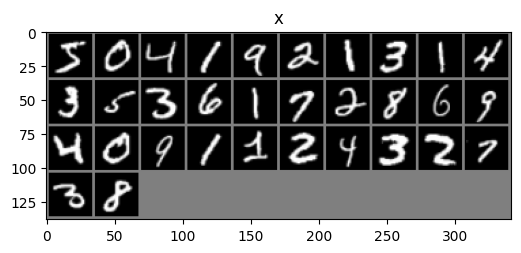

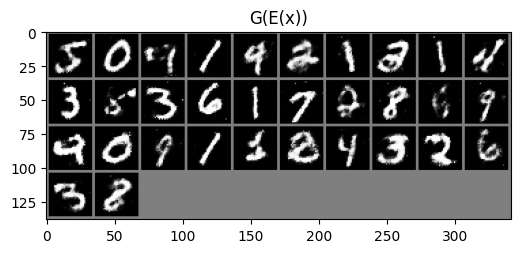

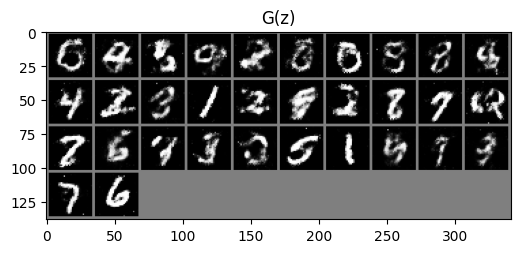

In [119]:
def show(imgs,title='G(z)',figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.title(title)
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()
z=FloatTensor(np.random.normal(size=(batch_size,z_dim)))
rec_imgs=g_model(e_model(inputs.cuda()))
gen_imgs=g_model(z)
show(inputs,'x')
show(rec_imgs,'G(E(x))')
show(gen_imgs,'G(z)')

In [120]:
img_dim = 128
z_dim = 128
num_layers = int(np.log2(img_dim)) - 3
max_num_channels = img_dim * 8
f_size = img_dim // 2**(num_layers + 1)
batch_size = 64

In [121]:
## 数据准备
from torch.utils.data import DataLoader
import os.path as osp
import glob
def make_datapath_list(root_path):
    """
    Returns:
    -----------
    path_list:list
    保存数据路径的列表
    """
    target_path=osp.join(root_path+'/**/*.jpg')
    
    #使用glob取得文件路径
    return glob.glob(target_path)

root_path='/kaggle/input/celeba'
l=make_datapath_list(root_path)
np.random.shuffle(l)
train_num=int(len(l)*0.8)
train_list=l[:train_num]
test_list=l[train_num:]
len(test_list)


40520

In [123]:
#创建Dataset
from torch.utils import data
import torchvision
from PIL import Image
class CelebDataset(data.Dataset):
    """
    file_path:list
    transform:object
    phase:'train' or 'val'
    """
    def __init__(self,file_list,transform=None,phase='train'):
        self.file_list=file_list
        self.transform=transform
        self.phase=phase
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,index):
        """
        获取预处理完毕的图片的张量数据和标签
        """
        img_path=self.file_list[index]
        img=Image.open(img_path)
        img_tranformed=self.transform(img)
        return img_tranformed
    
transform = transforms.Compose([
                               transforms.Resize((img_dim,img_dim)),
                               transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5))])
train_dataset=CelebDataset(file_list=train_list,transform=transform,phase='train')
test_dataset=CelebDataset(file_list=test_list,transform=transform,phase='test')

index=1
print(train_dataset.__getitem__(index))
print(train_dataset.__getitem__(index)[0].size())


tensor([[[ 0.7961,  0.6706,  0.5843,  ...,  0.7725,  0.7725,  0.7725],
         [ 0.8039,  0.6706,  0.5922,  ...,  0.7725,  0.7725,  0.7725],
         [ 0.7725,  0.7098,  0.7255,  ...,  0.7725,  0.7725,  0.7725],
         ...,
         [ 0.1137,  0.3020,  0.1686,  ..., -0.5137, -0.5608, -0.5843],
         [ 0.1765,  0.4353,  0.2941,  ..., -0.4510, -0.5608, -0.6078],
         [ 0.2471,  0.2471, -0.0196,  ..., -0.4431, -0.5294, -0.5529]],

        [[ 0.5608,  0.6392,  0.6941,  ...,  0.7804,  0.7804,  0.7804],
         [ 0.6235,  0.6235,  0.6235,  ...,  0.7804,  0.7804,  0.7804],
         [ 0.6392,  0.5922,  0.5686,  ...,  0.7804,  0.7804,  0.7804],
         ...,
         [ 0.1059,  0.2863,  0.1373,  ..., -0.6471, -0.6941, -0.7176],
         [ 0.1686,  0.4196,  0.2627,  ..., -0.5843, -0.6941, -0.7412],
         [ 0.2392,  0.2314, -0.0588,  ..., -0.5765, -0.6627, -0.6863]],

        [[ 0.8431,  0.7961,  0.7176,  ...,  0.8196,  0.8196,  0.8196],
         [ 0.8353,  0.7490,  0.6392,  ...,  0

In [124]:
#创建DataLoader
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
                                             shuffle=True,drop_last=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,
                                            shuffle=False,drop_last=True)
dataloaders_dict={
    'train':train_dataloader,
    'test':test_dataloader
}

batch_iter=iter(dataloaders_dict['train'])#转成迭代器
inputs=next(batch_iter)#取第一个元素
print(inputs.size())


torch.Size([64, 3, 128, 128])


In [131]:
class Encoder(nn.Module):
    def __init__(self,z_dim,bias=True):
        super().__init__()
        self.layer_list=[]
        self.z_dim=z_dim
        nc=3
        for i in range(num_layers+1):
            num_channels=(max_num_channels)//(2**(num_layers-i))
            self.layer_list.append(
                nn.Conv2d(nc,num_channels,5,2,2,bias=bias)
            )
            nc=num_channels
            if i>0:
                self.layer_list.append(nn.BatchNorm2d(nc))
            self.layer_list.append(nn.LeakyReLU(0.2))
        self.layer_list.append(nn.Flatten())
        input_size=f_size*f_size*nc
        self.layers=nn.Sequential(*self.layer_list)
        self.fc=nn.Sequential(nn.Linear(input_size,z_dim,bias=bias))
    def forward(self,x):
        return self.fc(self.layers(x))

class Decoder(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        self.z_dim=z_dim
        input_size=f_size**2*max_num_channels
        self.fc=nn.Sequential(
            nn.Linear(z_dim,input_size),
            nn.BatchNorm1d(input_size),
            nn.ReLU(),
        )
        
        self.conv_list=[]
        nc=max_num_channels
        for i in range(num_layers):
            num_channels=(max_num_channels)//(2**(i+1))
            self.conv_list.append(nn.Upsample(scale_factor=2.0))
            self.conv_list.append(nn.Conv2d(nc,num_channels,5,1,2))
            self.conv_list.append(nn.BatchNorm2d(num_channels))
            self.conv_list.append(nn.ReLU())
            nc=num_channels
        self.conv_list.append(nn.Upsample(scale_factor=2.0))
        self.conv_list.append(nn.Conv2d(nc,3,5,1,2))
        self.conv_list.append(nn.Tanh())
        self.conv=nn.Sequential(*self.conv_list)
    def forward(self,x):
        x=self.fc(x)
        x=x.view((-1,max_num_channels,f_size,f_size))
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self,z_dim):
        super().__init__()
        self.z_dim=z_dim
        self.fc=nn.Sequential(
            nn.Linear(self.z_dim*2,1024,bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1024,bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1,bias=False),
        )
    def forward(self,x):
        return self.fc(x)
        
        
e_test=Encoder(128)
code=e_test(inputs)
g_test=Decoder(128)
g_test(code).shape,inputs.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 3, 128, 128]))

In [133]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr=0.0002
b1=0.5
b2=0.999
batches=10000
z_dim=128
G_trains=1
D_trains=2
e_model=Encoder(z_dim).to(device)
te_model=Encoder(z_dim,False).to(device)
g_model=Decoder(z_dim).to(device)
d_model=Discriminator(z_dim).to(device)

import itertools
optimizer_G=torch.optim.Adam(itertools.chain(e_model.parameters(),g_model.parameters()),
                              lr=lr, betas=(b1, b2))
optimizer_D= torch.optim.Adam(itertools.chain(te_model.parameters(),d_model.parameters()),
                                 lr=lr, betas=(b1, b2))


cuda=1 if torch.cuda.is_available() else 0
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def show(imgs,figsize=(6,6)):
    plt.figure(figsize=figsize)
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()

fixed_z=FloatTensor(np.random.normal(size=(batch_size,z_dim)))



[batch 1500/5000]:


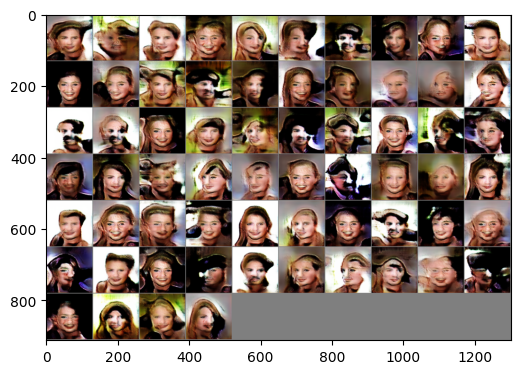

iter: 1501, d_loss: -3.5280215740203857, g_loss: 11.097128868103027
iter: 1502, d_loss: -3.4075238704681396, g_loss: 11.347479820251465
iter: 1503, d_loss: -3.3746371269226074, g_loss: 11.394596099853516
iter: 1504, d_loss: -3.549398422241211, g_loss: 11.187925338745117
iter: 1505, d_loss: -3.275282382965088, g_loss: 9.05711555480957
iter: 1506, d_loss: -2.911818504333496, g_loss: 8.443924903869629
iter: 1507, d_loss: -3.5048437118530273, g_loss: 9.643087387084961
iter: 1508, d_loss: -3.501491069793701, g_loss: 10.858344078063965
iter: 1509, d_loss: -3.379467248916626, g_loss: 10.596603393554688
iter: 1510, d_loss: -3.5751824378967285, g_loss: 10.800834655761719
iter: 1511, d_loss: -3.547863483428955, g_loss: 11.01771354675293
iter: 1512, d_loss: -3.1255176067352295, g_loss: 11.397729873657227
iter: 1513, d_loss: -3.5425257682800293, g_loss: 9.70222282409668
iter: 1514, d_loss: -3.7605819702148438, g_loss: 11.531664848327637
iter: 1515, d_loss: -3.065298080444336, g_loss: 9.90737819671

KeyboardInterrupt: 

In [134]:
batches=5000
g_loss_list=[]
d_loss_list=[]
def get_infinite_data(dataloader):
    while True:
        for image in dataloader:
            yield image
training_dataloader=get_infinite_data(train_dataloader)
def get_batch():
    return training_dataloader.__next__().to(device)
def set_trainable(model,state):
    for param in model.parameters():
            param.requires_grad_(state)
for i in range(batches):
    set_trainable(e_model,False)
    set_trainable(g_model,False)
    set_trainable(te_model,True)
    set_trainable(d_model,True)
    for _ in range(D_trains):
        x_real=get_batch()
        z_fake=FloatTensor(np.random.normal(size=(batch_size,z_dim)))
        x_fake=g_model(z_fake)
        z_real=e_model(x_real)
        x_real_te=te_model(x_real)
        x_fake_te=te_model(x_fake)
        
        xz_real=torch.cat([x_real_te,z_real],dim=1)
        xz_fake=torch.cat([x_fake_te,z_fake],dim=1)
        
        xz_real_score=d_model(xz_real)
        xz_fake_score=d_model(xz_fake)
        
        optimizer_D.zero_grad()
        
        d_loss=xz_real_score-xz_fake_score
        d_loss=d_loss[:,0]
        d_norm=10*torch.mean((x_real-x_fake).abs(),dim=(1,2,3))+torch.mean((z_real-z_fake).abs(),dim=1)
        d_loss=torch.mean(-d_loss+0.5*d_loss**2/d_norm)
        
        d_loss.backward()
        optimizer_D.step()
        #print(d_loss)
    
    set_trainable(e_model,True)
    set_trainable(g_model,True)
    set_trainable(te_model,False)
    set_trainable(d_model,False)
    for _ in range(G_trains):
        x_real=get_batch()
        z_fake=FloatTensor(np.random.normal(size=(batch_size,z_dim)))
        x_fake=g_model(z_fake)
        z_real=e_model(x_real)
        x_real_rec=g_model(z_real.detach())
        z_fake_rec=e_model(x_fake.detach())
        
        x_real_te=te_model(x_real)
        x_fake_te=te_model(x_fake)
        xz_real=torch.cat([x_real_te,z_real],dim=1)
        xz_fake=torch.cat([x_fake_te,z_fake],dim=1)
        
        xz_real_score=d_model(xz_real)
        xz_fake_score=d_model(xz_fake)
        
        optimizer_G.zero_grad()
        
        g_loss=torch.mean(xz_real_score-xz_fake_score)+2*torch.mean(
            torch.square(z_fake-z_fake_rec))+3*torch.mean(torch.square(x_real-x_real_rec))
        
        g_loss.backward()
        optimizer_G.step()
    
    print(f"iter: {i}, d_loss: {d_loss}, g_loss: {g_loss}")
    
    batch_done=i
    if(batch_done%100==0):
        clear_output()
        print('[batch %d/%d]:'%(i,batches))
        with torch.no_grad():
            fake_img=g_model(fixed_z)
        show(fake_img)
        #plt.plot(range(batch_done+1),g_loss_list)
        #plt.plot(range(batch_done+1),d_loss_list)
        
        

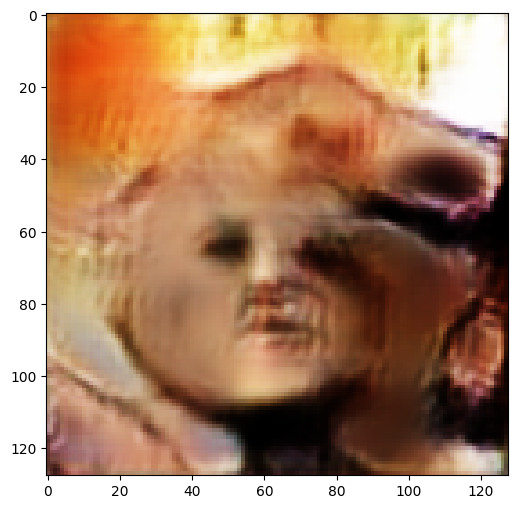

In [135]:
def show_a_image(imgs):
    plt.figure(figsize=(6,6))
    #imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs[1].detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()
fake_img=g_model(fixed_z)
show_a_image(fake_img)

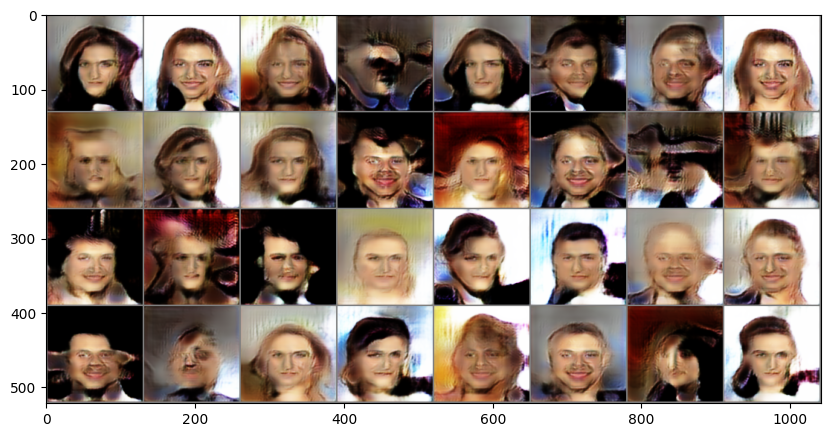

In [137]:
def show_k_images(k,imgs=None,name='faces.png'):
    plt.figure(figsize=(10,10))
    if imgs==None:
        z=torch.rand((k,z_dim)).to(device)
        imgs=g_model(z)
    imgs=torchvision.utils.make_grid(imgs,nrow=8,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.savefig(name)
    plt.show()

show_k_images(32,None,'faces_32.png')

## 存在明显的模式崩溃，原因未知